# FM/I/FM Magnetic Tunnel Junction

In this example, we demonstrate transport calculations for a ferromagnetic/insulator/ferromagnetic (FM/I/FM) magnetic tunnel junction (MTJ), where an insulating (I) barrier is sandwiched between two semi-infinite ferromagnetic (FM) electrodes. This example reproduces the results from Phys. Rev. B 81, 054437 (2010).

## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import junpy as jp
from junpy.factory import stack
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'font.size': 12}

## Build Device

In this device, the chemical potentials (`uL` and `uR`) and spin angles (`sL` and `sR`) of the left and right FM regions are adjustable. The onsite energy of the non-magnetic insulator is set to `5.4`, with the number of sites defined as `NB=5`. A linear potential drop, `np.arange(NB)*dV`, is applied across the insulator. To simulate the properties of a 3D solid, translation symmetry along the $x$ and $y$ directions is enabled.

In [2]:
def build_device(uL=0, uR=0, sL=0, sR=0, NB=5):

    # energy parameters
    eL = ( 1.2, 2.0) # [eV] onsite energy of the left lead
    eB = ( 5.4, 5.4) # [eV] onsite energy of the insulator
    eR = ( 1.2, 2.0) # [eV] onsite energy of the right lead
    t  = (-0.4,-0.4) # [eV] hopping energy in all regions

    # potential drop in the barrier
    dV = (uR-uL)/(NB-1)

    # define the two-probe device
    builder = stack.TwoProbeDeviceBuilder()
    builder.L.set(chemicalPotential=uL, temperature=0)
    builder.L.add(eL, t, nsites=1,  spin=sL, bias=uL)
    builder.C.add(eL, t, nsites=1,  spin=sL, bias=uL)
    builder.C.add(eB, t, nsites=NB, spin=0,  bias=np.arange(NB)*dV)
    builder.C.add(eR, t, nsites=1,  spin=sR, bias=uR)
    builder.R.add(eR, t, nsites=1,  spin=sR, bias=uR)
    builder.R.set(chemicalPotential=uR, temperature=0)

    # define coupling between layers
    builder.set_layer_coupling(all=t)

    # define translation symmetry
    builder.set_translationSymmetry(x=True, y=True)

    # create device
    return builder.create_device()

## Calculate Bias-Dependent Interfacial Spin Current

We define a function to create and return a bias-dependent `jp.SpinCurrent` calculation. In this setup, the spin angle of the left FM material is fixed to `np.pi/2`.

In [4]:
def build_calculation_of_bias(bias):
    calcr = jp.SpinCurrent(
        device=build_device(uR=bias, sL=np.pi/2, NB=5),
        kpoints=jp.SymmetryKspaceSampling((15,15,1)),
        nonequilibriumEnergies=jp.BiasWindow(interval=0.01),
        equilibriumEnergies=dict(
            circlePoints=30,
            lowestEnergy=-30))
    return calcr

Since there are multiple biases to calculate, the `jp.BiasBatchRunner` class is used to perform batch calculations efficiently. The bias is applied over the range from `-0.6` to `0.6`.

In [5]:
runner_bias = jp.BiasBatchRunner(
    biases=np.linspace(-0.6, 0.6, 13),
    factory=build_calculation_of_bias)
jp.run(runner_bias, savefile=False)

<<< Batch 1/13 >>>
JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating spin current... (2024-08-16 14:16:46)
    Device information
        bias (mu2-mu1)--------------------------: -0.6
        central.numberOfSites-------------------: 7
        central.spinType------------------------: SpinType.GeneralSpin
        lead1.numberOfSites---------------------: 1
        lead1.spinType--------------------------: SpinType.GeneralSpin
        lead1.direction-------------------------: -3
        lead1.temperature-----------------------: 0
        lead1.chemicalPotential-----------------: 0
        lead2.numberOfSites---------------------: 1
        lead2.spinType--------------------------: SpinT

In our device, the number of sites in the central region is `7`, so the number of interfaces is `6`. To retrieve the interfacial spin current between the barrier and the right FM material, we set `interface = 5` to get the 6th interface.

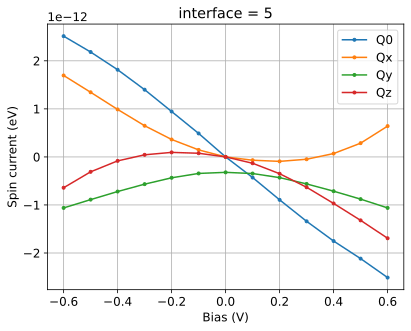

In [6]:
# shape: (#biases, #interfaces, #spin)
interfacial_current = runner_bias.get_by_attribute('interfacial_spin_current')

# 6th interface
interface = 5
interfacial_current_n = interfacial_current[:,interface,:]

plt.plot(runner_bias.biases, interfacial_current_n, '.-')
plt.title(f'interface = {interface}')
plt.xlabel('Bias (V)')
plt.ylabel('Spin current (eV)')
plt.legend(['Q0', 'Qx', 'Qy', 'Qz'])
plt.grid()
plt.show()

## Calculate Angle-Dependent Interfacial Spin Current

For angular dependency, we keep the bias `0.1` fixed while rotating the spin angle of the left FM material.

In [7]:
def build_calculation_of_angle(angle):
    calcr = jp.SpinCurrent(
        device=build_device(uR=0.1, sL=angle, NB=5),
        kpoints=jp.SymmetryKspaceSampling((15,15,1)),
        nonequilibriumEnergies=jp.BiasWindow(interval=0.01),
        equilibriumEnergies=dict(
            circlePoints=30,
            lowestEnergy=-30))
    return calcr

Similarly, we use `jp.AngleBatchRunner` to construct the batch calculations.

In [8]:
runner_angle = jp.AngleBatchRunner(
    angles=np.linspace(0, np.pi, 7),
    factory=build_calculation_of_angle)
jp.run(runner_angle, savefile=False)

<<< Batch 1/7 >>>
JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating spin current... (2024-08-16 14:18:42)
    Device information
        bias (mu2-mu1)--------------------------: 0.1
        central.numberOfSites-------------------: 7
        central.spinType------------------------: SpinType.GeneralSpin
        lead1.numberOfSites---------------------: 1
        lead1.spinType--------------------------: SpinType.GeneralSpin
        lead1.direction-------------------------: -3
        lead1.temperature-----------------------: 0
        lead1.chemicalPotential-----------------: 0
        lead2.numberOfSites---------------------: 1
        lead2.spinType--------------------------: SpinTyp

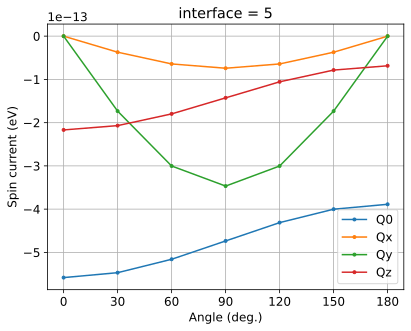

In [9]:
# shape: (#biases, #interfaces, #spin)
interfacial_current = runner_angle.get_by_attribute('interfacial_spin_current')

# 6th interface
interface = 5
interfacial_current_n = interfacial_current[:,interface,:]

plt.plot(runner_angle.angles/np.pi*180, interfacial_current_n, '.-')
plt.title(f'interface = {interface}')
plt.xlabel('Angle (deg.)')
plt.ylabel('Spin current (eV)')
plt.legend(['Q0', 'Qx', 'Qy', 'Qz'])
plt.xticks(runner_angle.angles/np.pi*180)
plt.grid()
plt.show()